In [1]:
import FC2_train_v2 as FC2_MPO_Net
from neural_networks import *

# Pre-processing

## 1. Train

In [2]:
D = 8

In [3]:
# List of layer 1 weights (0-3), layer 1 bias (4), layer 2 weights (5-8), layer 2 bias (9)
weights = FC2_MPO_Net.main(r_1=D, r_2=D)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Accuracy at step 0: 0.1111
Accuracy at step 1: 0.2356
Accuracy at step 2: 0.2979
Accuracy at step 4: 0.3036
Accuracy at step 8: 0.4436
Accuracy at step 9: 0.5199
Accuracy at step 11: 0.5471
Accuracy at step 12: 0.5472
Accuracy at step 17: 0.5815
Accu

## 2. Open weights matrices into correct MPO

In [4]:
sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

In [5]:
sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

## 3. Check that MPO is correct based on accuracy from model

In [6]:
acc, t = FC2(MPO_0, bias_0, MPO_1, bias_1)
print(acc, "%", t, "s")

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
88.49000000000001 % 0.0069828033447265625 s


## 4. Close legs to use for compression algorithm

In [7]:
MPS_0 = close_legs(MPO_0)
MPS_1 = close_legs(MPO_1)

In [8]:
bias_0_MPS = vector_to_left_canonical_MPS_NN(bias_0, phys_dim=[2, 2, 2, 2, 2, 2, 2, 2])
bias_1_MPS = vector_to_left_canonical_MPS_NN(bias_1, phys_dim=[2, 5])

## 5. Compress MPS layers

Sim: 0.06468877048011658 Dist: 32.247726037537454 BondDim: 1
Sim: 0.22501648491396228 Dist: 29.353997545686454 BondDim: 2
Sim: 0.4130894004485639 Dist: 25.545064155782544 BondDim: 3
Sim: 0.591602333901736 Dist: 21.308979277516684 BondDim: 4
Sim: 0.7404383198694718 Dist: 16.98796312512811 BondDim: 5
Sim: 0.8526682513172583 Dist: 12.79879824419086 BondDim: 6
Sim: 0.9427980801636626 Dist: 7.974919791597158 BondDim: 7


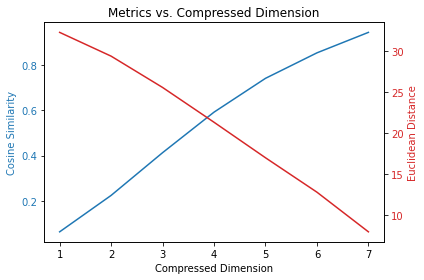

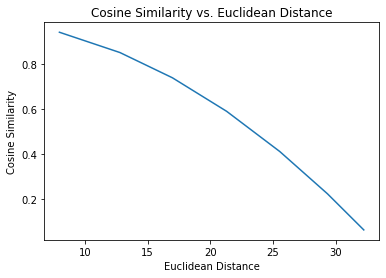

In [9]:
compressed_MPS_0, dist0, sim0 = compress_layer(MPS_0, phys_dim=[16, 28, 28, 16], threshold=1e-8, plot=1)
dist0.append(metrics.overlap(MPS_0, MPS_0))
sim0.append(metrics.similarity(MPS_0, MPS_0))
compressed_MPS_0.append(MPS_0)

Sim: 0.1592740083409707 Dist: 6.392738134672638 BondDim: 1
Sim: 0.40314399268419365 Dist: 5.386348665294254 BondDim: 2
Sim: 0.6447151288329261 Dist: 4.155736809315821 BondDim: 3
Sim: 0.8234504041848473 Dist: 2.9294968918590776 BondDim: 4
Sim: 0.9243260674325796 Dist: 1.9179303408704889 BondDim: 5
Sim: 0.9664013489249649 Dist: 1.2779698221111817 BondDim: 6
Sim: 0.9910677632857604 Dist: 0.6589307722027111 BondDim: 7


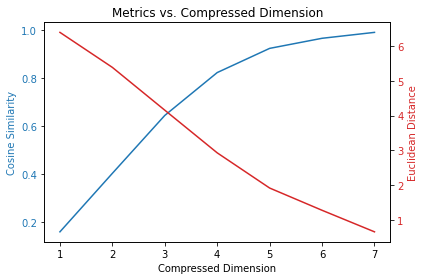

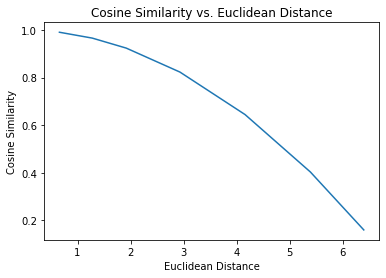

In [10]:
compressed_MPS_1, dist1, sim1 = compress_layer(MPS_1, phys_dim=[4, 40, 4, 4], threshold=1e-8, plot=1)
dist1.append(metrics.overlap(MPS_1, MPS_1))
sim1.append(metrics.similarity(MPS_1, MPS_1))
compressed_MPS_1.append(MPS_1)

## 6. Percentage compressed at each bond dimension compared to trained bond dimension

In [11]:
print("Orig:", 784*256)
for i in range(len(compressed_MPS_0)):
    print(i+1, round(calculate_params(compressed_MPS_0[i])/(784*256)*100, 2), "% of Orig")

Orig: 200704
1 0.04 % of Orig
2 0.14 % of Orig
3 0.3 % of Orig
4 0.51 % of Orig
5 0.78 % of Orig
6 1.1 % of Orig
7 1.48 % of Orig
8 1.91 % of Orig


In [12]:
print("Orig:", 256*10)
for i in range(len(compressed_MPS_1)):
    print(i+1, round(calculate_params(compressed_MPS_1[i])/(256*10)*100, 2), "% of Orig")

Orig: 2560
1 2.03 % of Orig
2 7.5 % of Orig
3 16.41 % of Orig
4 28.75 % of Orig
5 35.62 % of Orig
6 42.5 % of Orig
7 49.38 % of Orig
8 112.5 % of Orig


# Accuracy Tests

## 1. Check accuracy when compressing one layer at a time

In [15]:
### Check changes in W0 for constant W1
acc_compressed = []
time_compressed = []
W1_dim = len(compressed_MPS_1)
MPS_1_test = MPS_1
params0 = []
for W0_dim in range(1, len(compressed_MPS_0)+1):
    print("dim:", W0_dim)
    MPS_0_test = compressed_MPS_0[W0_dim-1]

    dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
    dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
    MPO_0_test = open_legs(MPS_0_test, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=dim_0)
    MPO_1_test = open_legs(MPS_1_test, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=dim_1)

    acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
    acc_compressed.append(acc)
    time_compressed.append(t)

    total_params = 0
    for tensor in MPS_0_test:
        total_params += tensor.size
    params0.append(total_params)

params_orig = 0
for tensor in MPS_0:
    params_orig += tensor.size
acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
loss0 = [acc_orig-x for x in acc_compressed]
params0 = np.array(params0)/params_orig*100

### Check changes in W1 for constant W0
acc_compressed = []
time_compressed = []
W0_dim = len(compressed_MPS_0)
MPS_0_test = MPS_0
params1 = []
for W1_dim in range(1, len(compressed_MPS_1)+1):
    print("dim:", W1_dim)
    MPS_1_test = compressed_MPS_1[W1_dim-1]

    dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
    dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
    MPO_0_test = open_legs(MPS_0_test, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=dim_0)
    MPO_1_test = open_legs(MPS_1_test, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=dim_1)

    acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
    acc_compressed.append(acc)
    time_compressed.append(t)

    total_params = 0
    for tensor in MPS_1_test:
        total_params += tensor.size
    params1.append(total_params)

params_orig = 0
for tensor in MPS_1:
    params_orig += tensor.size
acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
loss1 = [acc_orig-x for x in acc_compressed]
params1 = np.array(params1)/params_orig*100

dim: 1
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 2
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 3
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 4
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 5
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 6
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train

Text(0, 0.5, 'Loss [%]')

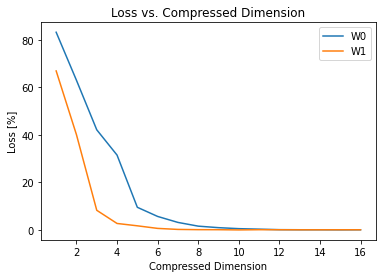

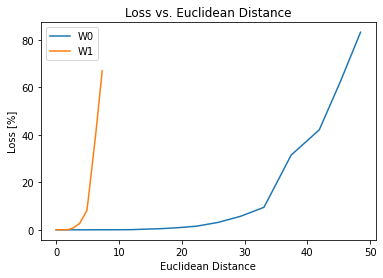

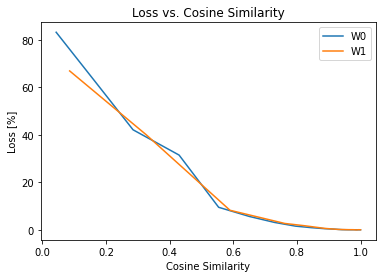

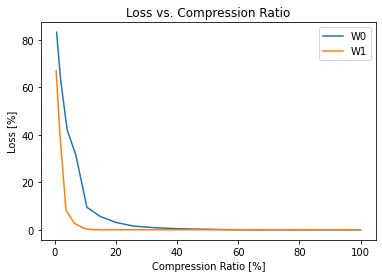

In [16]:
plt.figure()

plt.plot(range(1, len(compressed_MPS_0)+1), loss0, label="W0")
plt.plot(range(1, len(compressed_MPS_1)+1), loss1, label="W1")

plt.legend()
plt.title('Loss vs. Compressed Dimension')
plt.xlabel('Compressed Dimension')
plt.ylabel('Loss [%]')

plt.figure()
plt.plot(dist0, loss0, label="W0")
plt.plot(dist1, loss1, label="W1")
plt.legend()
plt.title('Loss vs. Euclidean Distance')
plt.xlabel('Euclidean Distance')
plt.ylabel('Loss [%]')

plt.figure()
plt.plot(sim0, loss0, label="W0")
plt.plot(sim1, loss1, label="W1")
plt.legend()
plt.title('Loss vs. Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Loss [%]')

plt.figure()
plt.plot(params0, loss0, label="W0")
plt.plot(params1, loss1, label="W1")
plt.legend()
plt.title('Loss vs. Compression Ratio')
plt.xlabel('Compression Ratio [%]')
plt.ylabel('Loss [%]')

# Heatmap

## 1. Calculate accuracy at each node for all compressed dimension combinations

In [13]:
acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
acc_matrix = []
for W0_dim in range(1, len(compressed_MPS_0)+1):
    acc_array = []
    MPS_0_test = compressed_MPS_0[W0_dim-1]
    for W1_dim in range(1, len(compressed_MPS_1)+1):
        MPS_1_test = compressed_MPS_1[W1_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=dim_1)


        acc, _ = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        acc_array.append(acc)
    acc_matrix.append(acc_array)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

## 2. Compression ratio for all nodes

In [14]:
orig_params = calculate_params(MPS_0)+calculate_params(MPS_1)
params_matrix = []
compression_ratio_matrix = []
for i in range(len(compressed_MPS_0)):
    compression_ratio = []
    for j in range(len(compressed_MPS_1)):
        params = calculate_params(compressed_MPS_0[i]) + calculate_params(compressed_MPS_1[j])
        compression_ratio.append(round(params/orig_params*100, 2))
    compression_ratio_matrix.append(compression_ratio)

## 3. Heatmap for loss below given threshold

In [33]:
threshold = 1

Best Compression: 51.67 %
W0_dim =  6
W1_dim =  7


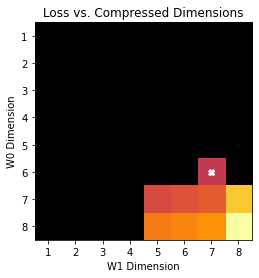

In [34]:
compression_ratio_plot = np.array(compression_ratio_matrix[:])
acc_matrix_plot = np.array(acc_matrix[:])
loss = np.array([acc_orig-x for x in acc_matrix_plot])
compression_ratio_plot[loss > threshold] = 0

fig, ax = plt.subplots()
im = ax.imshow(compression_ratio_plot, cmap='inferno')
ax.set_xticks(np.arange(len(compressed_MPS_0)))
ax.set_yticks(np.arange(len(compressed_MPS_1)))
ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

plt.xlabel('W1 Dimension')
plt.ylabel('W0 Dimension')
plt.title('Loss vs. Compressed Dimensions')
try:
    minval = np.min(compression_ratio_plot[np.nonzero(compression_ratio_plot)])
    ij = np.where(compression_ratio_plot == minval)
    plt.plot(ij[1], ij[0], 'wX')
    print("Best Compression:", minval, "%")
    print("W0_dim = ", ij[0][0]+1)
    print("W1_dim = ", ij[1][0]+1)
except:
    print("Layers cannot be compressed and still reach given threshold")


# Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(compression_ratio_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

## 4. Full Heatmap

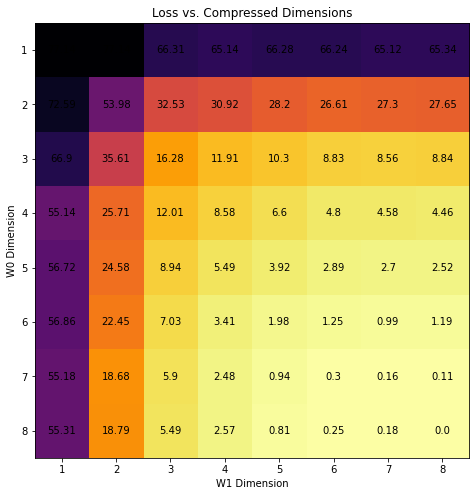

In [36]:
### Plotting
loss_plot = loss[:]
plt.figure(figsize = (8,8))
plt.imshow(loss, cmap='inferno_r')

plt.xticks(np.arange(len(compressed_MPS_0)), labels=np.arange(1, len(compressed_MPS_0)+1))
plt.yticks(np.arange(len(compressed_MPS_1)), labels=np.arange(1, len(compressed_MPS_1)+1))
plt.xlabel(np.arange(1, len(compressed_MPS_0)+1))
plt.ylabel(np.arange(1, len(compressed_MPS_1)+1))

plt.xlabel('W1 Dimension')
plt.ylabel('W0 Dimension')
plt.title('Loss vs. Compressed Dimensions')

# Loop over data dimensions and create text annotations.
for i in range(len(compressed_MPS_0)):
    for j in range(len(compressed_MPS_1)):
        text = plt.text(j, i, np.round(loss[i][j], 2),
                       ha="center", va="center", color="k")

# Optimizing Bond Dimensions

In [40]:
def compress_layer_single_dim(raw_state, phys_dim, threshold, compressed_dim, compressed_state=0, plot=0):
    """ Initializes a compressed state then sweeps left->right
        and right->left until a minimum is reached
        i.e. the difference in our metrics between sweeps is less than a
        specified threshold up to the bond dimension of the raw state

        Note: Does NOT normalize the state unlike the compression function
              found in compression.py

    Args:
        raw_state: MPS to be compressed
        phys_dim: List of physical dimensions by site
        threshold: Difference between sweeps under which a solution is found
        compressed_state: Initial starting state if necessary
                          otherwise a random MPS is ini
        plot: Whether or not to plot the compression values (0 off, 1 on)

    Returns:
        compressions: Final compressed state at each bond dimension
        best_dist: List of overlap values for each bond dimension
        best_sim: List of cosine similarity values for each bond dimension
    """
    compressed_state = init.initialize_random_MPS_with_changing_phys_dim(phys_dim,
                                                                         num_sites=len(raw_state),
                                                                         bond_dim=compressed_dim)
    bond_dim_raw_state = raw_state[math.ceil(len(raw_state)/2)].shape[0]

    # Initialize accuracy metrics
    dist = []  # Frobenius norm
    sim = []   # Cosine similarity (Scalar product)
    dist.append(metrics.overlap(compressed_state, raw_state))
    sim.append(metrics.similarity(compressed_state, raw_state))
    # We sweep left to right and then back right to left across the mixed state
    while True:
        # Left->right sweep
        for site in range(0, len(raw_state)-1):
            compressed_state[site], compressed_state[site+1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='right')
        # Right->left sweep
        for site in range(len(raw_state)-1, 0, -1):
            compressed_state[site], compressed_state[site-1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='left')

        # Metrics taken after each sweep
        dist.append(metrics.overlap(compressed_state, raw_state))
        sim.append(metrics.similarity(compressed_state, raw_state))
        # Check if sweeps are still working
        if np.abs(dist[-2]-dist[-1]) < threshold:
            # Normalize to maintain length and update metrics
            #compressed_state, _ = can.left_normalize(compressed_state)
            #best_dist.append((metrics.overlap(compressed_state, raw_state)))
            #best_sim.append(metrics.scalar_product(compressed_state, raw_state))
            if plot == 0:
                print("Sim:", sim[-1], "Dist:", dist[-1], "BondDim:", compressed_dim)
            #compressions.append(compressed_state[:])
            break

    return compressed_state, dist, sim


## 1. Depth-First Search

In [47]:
### Optimized path
# 1. Starting state
# 2. Compress all layers down by 1
# 3. Calculate delta_params in all directions
# 4. Calculate delta_acc in all directions
# 5. Moved based on minimizing delta_acc/delta_params

sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

layers = [MPO_0, MPO_1]

acc_orig, _ = FC2(MPO_0, bias_0, MPO_1, bias_1)
threshold = 1
last_updated = np.ones(len(layers))
loss = 0
while True:
    print(loss)
    # 1. Starting state
    MPS_0 = close_legs(layers[0])
    MPS_1 = close_legs(layers[1])

    # 2. Compress all layers down by 1
    dim0 = MPS_0[math.ceil(len(MPS_0)/2)].shape[0]
    dim1 = MPS_1[math.ceil(len(MPS_1)/2)].shape[0]
    
    if last_updated[0] == 1:
        compressed_0, _, _ = compress_layer_single_dim(MPS_0, phys_dim=[16,28,28,16], threshold=1e-6, compressed_dim=dim0-1)
        bonds0 = [compressed_0[0].shape[1], compressed_0[1].shape[1], compressed_0[2].shape[1], compressed_0[3].shape[1]]
        new_MPO_0 = open_legs(compressed_0, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=bonds0)
    if last_updated[1] == 1:
        compressed_1, _, _ = compress_layer_single_dim(MPS_1, phys_dim=[4,40,4,4], threshold=1e-6, compressed_dim=dim1-1)
        bonds1 = [compressed_1[0].shape[1], compressed_1[1].shape[1], compressed_1[2].shape[1], compressed_1[3].shape[1]]
        new_MPO_1 = open_legs(compressed_1, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=bonds1)
    MPOs = [new_MPO_0, new_MPO_1]

    # 3. Calculate delta_params
    delta_params0 = calculate_params(MPO_0) - calculate_params(new_MPO_0)
    delta_params1 = calculate_params(MPO_1) - calculate_params(new_MPO_1)
    new_params = [delta_params0, delta_params1]

    # 4. Calculate delta_acc
    new_acc0, _ = FC2(new_MPO_0, bias_0, layers[1], bias_1)
    new_acc1, _ = FC2(layers[0], bias_0, new_MPO_1, bias_1)
    new_loss = [acc_orig-new_acc0, acc_orig-new_acc1]

    delta_loss0 = loss - new_loss[0]
    delta_loss1 = loss - new_loss[1]

    # 5. Calculate slope
    slope = [new_loss[0]/new_params[0], new_loss[1]/new_params[1]]
    for i, loss in enumerate(new_loss):
        if loss > threshold:
            slope[i] = np.inf
    # 6. Find minimum slope
    index = np.argmin(slope)

    # 7. Update layers
    if new_loss[0] > threshold and new_loss[1] > threshold:
        break
    else:
        layers[index] = MPOs[index]
        loss = new_loss[index]
        last_updated = np.zeros(len(layers))
        last_updated[index] = 1
        print(last_updated)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0
Sim: 0.9427980750899791 Dist: 7.974920145276026 BondDim: 7
Sim: 0.9910677617610612 Dist: 0.6589308284411898 BondDim: 7
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
[0. 1.]
0.18000000000000682
Sim: 0.97511126042903 Dist: 1.094996684220218 BondDim: 6
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-u

In [53]:
### Params compared to trained MPO model
orig_params = calculate_params(MPO_0) + calculate_params(MPO_1)
params = calculate_params(layers[0]) + calculate_params(layers[1])
print(round(params/orig_params*100, 2), "%")

57.74 %


In [54]:
### Params compared to typical model
orig_params = 784*256 + 256*10
params = calculate_params(layers[0]) + calculate_params(layers[1])
print(round(params/orig_params*100, 2), "%")

1.95 %


## 2. Permutation Search (layer_to_compress chooses starting layer)

In [56]:
### Permutations
# 1. Starting state
# 2. Compress single layer down until threshold
# 3. Switch layers

sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

layers = [MPO_0, MPO_1]

acc_orig, _ = FC2(MPO_0, bias_0, MPO_1, bias_1)
threshold = 5
last_updated = np.ones(len(layers))
acc = acc_orig
print(acc_orig-acc)
# 1. Starting state
MPS_0 = close_legs(layers[0])
MPS_1 = close_legs(layers[1])

# 2. Compress single layer down until acc less than threshold
dim0 = MPS_0[math.ceil(len(MPS_0)/2)].shape[0]
dim1 = MPS_1[math.ceil(len(MPS_1)/2)].shape[0]

layer_to_compress = 0
for i in range(len(layers)):
    if layer_to_compress == 0:
        while True:
            compressed_0, _, _ = compress_layer_single_dim(MPS_0, phys_dim=[16,28,28,16], threshold=1e-6, compressed_dim=dim0-1)
            bonds0 = [compressed_0[0].shape[1], compressed_0[1].shape[1], compressed_0[2].shape[1], compressed_0[3].shape[1]]
            new_MPO = open_legs(compressed_0, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=bonds0)
            new_acc, _ = FC2(new_MPO, bias_0, layers[1], bias_1)
            print(acc_orig-new_acc)
            if acc_orig-new_acc > threshold:
                layer_to_compress = 1
                break
            else:
                layers[layer_to_compress] = new_MPO
                dim0 = dim0-1

    elif layer_to_compress == 1:
        while True:
            compressed_1, _, _ = compress_layer_single_dim(MPS_1, phys_dim=[4,40,4,4], threshold=1e-6, compressed_dim=dim1-1)
            bonds1 = [compressed_1[0].shape[1], compressed_1[1].shape[1], compressed_1[2].shape[1], compressed_1[3].shape[1]]
            new_MPO = open_legs(compressed_1, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=bonds1)
            new_acc, _ = FC2(layers[0], bias_0, new_MPO, bias_1)
            print(acc_orig-new_acc)
            if acc_orig-new_acc > threshold:
                layer_to_compress = 0
                break
            else:
                layers[layer_to_compress] = new_MPO
                dim1 = dim1-1

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.0
Sim: 0.9427980753146402 Dist: 7.974920129615225 BondDim: 7
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.10999999999999943
Sim: 0.8526682084733472 Dist: 12.798800105128976 BondDim: 6
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
1.210000000000008
Sim: 0.7404383018987327 Dist: 16.987963713208455 BondDim: 5
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
2.5200000000000102
Sim: 0.5916022179897337 Dist: 21.308982301488772

In [57]:
### Params compared to trained MPO model
orig_params = calculate_params(MPO_0) + calculate_params(MPO_1)
params = calculate_params(layers[0]) + calculate_params(layers[1])
print(round(params/orig_params*100, 2), "%")

31.43 %


In [62]:
### Params compared to typical model
orig_params = 784*256 + 256*10
params = calculate_params(layers[0]) + calculate_params(layers[1])
print(round(params/orig_params*100, 2), "%")

1.06 %


In [61]:
acc, _ = FC2(layers[0], bias_0, layers[1], bias_1)
print(acc_orig-acc)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
4.8100000000000165
